# Analyzing cancer gene comutation dependencies

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

In [3]:
from speclet.analysis.sublineage_model_analysis import load_sublineage_model_posteriors
from speclet.io import DataFile, data_path, notebook_output_and_stash_dirs
from speclet.plot import set_speclet_theme
from speclet.plot.color_pal import lineage_color_pal, sublineage_color_pal
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 709
np.random.seed(RANDOM_SEED)
arviz_config()

In [5]:
OUTPUT_DIR, STASH_DIR = notebook_output_and_stash_dirs(
    "005_100_lineage-data-exploration"
)

### Data

#### Model posteriors

In [6]:
postmen = load_sublineage_model_posteriors()

In [8]:
sublineage_pal = sublineage_color_pal()
lineage_pal = lineage_color_pal()

## Analysis

### Hierarchical clustering by LFC

In [9]:
lineage_subtypes = [pm.config.model_kwargs["lineage"] for pm in postmen.posteriors]

In [10]:
depmap_df = dd.read_csv(
    data_path(DataFile.DEPMAP_DATA),
    low_memory=False,
    usecols=[
        "sgrna",
        "hugo_symbol",
        "depmap_id",
        "lfc",
        "screen",
        "lineage",
        "lineage_subtype",
        "primary_or_metastasis",
    ],
).query("screen == 'broad'")

In [11]:
gene_variances_stash_fp = STASH_DIR / "gene_variances-stash.csv"
if gene_variances_stash_fp.exists():
    gene_variances = pd.read_csv(gene_variances_stash_fp)
else:
    gene_variances = (
        depmap_df.groupby("hugo_symbol")["lfc"]
        .var()
        .compute()
        .reset_index()
        .rename(columns={"lfc": "lfc_var"})
    )
    gene_variances.to_csv(gene_variances_stash_fp, index=False)

gene_variances.head()

,hugo_symbol,lfc_var
0,A1BG,0.139119
1,A1CF,0.164934
2,A2M,0.136484
3,A2ML1,0.134801
4,A3GALT2,0.254192


In [12]:
def _make_new_lineage_col(df: pd.DataFrame) -> pd.DataFrame:
    new_col = [f"{ln}_({st})" for ln, st in zip(df["lineage"], df["lineage_subtype"])]
    df = df.assign(lineage_subtype=new_col)
    return df

In [13]:
cutoff = np.quantile(gene_variances["lfc_var"], 0.8)
top_var_genes = gene_variances[gene_variances["lfc_var"] > cutoff][
    "hugo_symbol"
].toset()
top_var_data_stash_fp = STASH_DIR / "top_var_data-stash.csv"
if top_var_data_stash_fp.exists():
    top_var_data = pd.read_csv(top_var_data_stash_fp)
else:
    top_var_data = (
        depmap_df.query(
            "hugo_symbol in @top_var_genes", local_dict={"top_var_genes": top_var_genes}
        )
        .compute()
        .pipe(_make_new_lineage_col)
        .filter_column_isin("lineage_subtype", lineage_subtypes)
    )
    top_var_data.to_csv(top_var_data_stash_fp, index=False)
top_var_data.shape

/tmp/ipykernel_13969/955944050.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  top_var_data = pd.read_csv(top_var_data_stash_fp)


(9141760, 8)

In [14]:
top_var_data_X = (
    top_var_data.groupby(["lineage", "lineage_subtype", "depmap_id", "hugo_symbol"])[
        "lfc"
    ]
    .mean()
    .reset_index()
    .pivot_wider(
        "depmap_id",
        names_from="hugo_symbol",
        values_from="lfc",
    )
    .set_index("depmap_id")
)
top_var_data_X.shape

(640, 3624)

In [15]:
# Separate steps so can save before replacing with colors.
top_var_cg_row_labels = (
    top_var_data[["lineage", "lineage_subtype", "depmap_id"]]
    .drop_duplicates()
    .set_index("depmap_id")
    .assign(
        lineage=lambda d: [x.replace("_", " ") for x in d["lineage"]],
        lineage_subtype=lambda d: [x.replace("_", " ") for x in d["lineage_subtype"]],
    )
)
top_var_cg_row_colors = top_var_cg_row_labels.assign(
    lineage=lambda d: d["lineage"].map(lineage_pal),
    lineage_subtype=lambda d: d["lineage_subtype"].map(sublineage_pal),
)

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


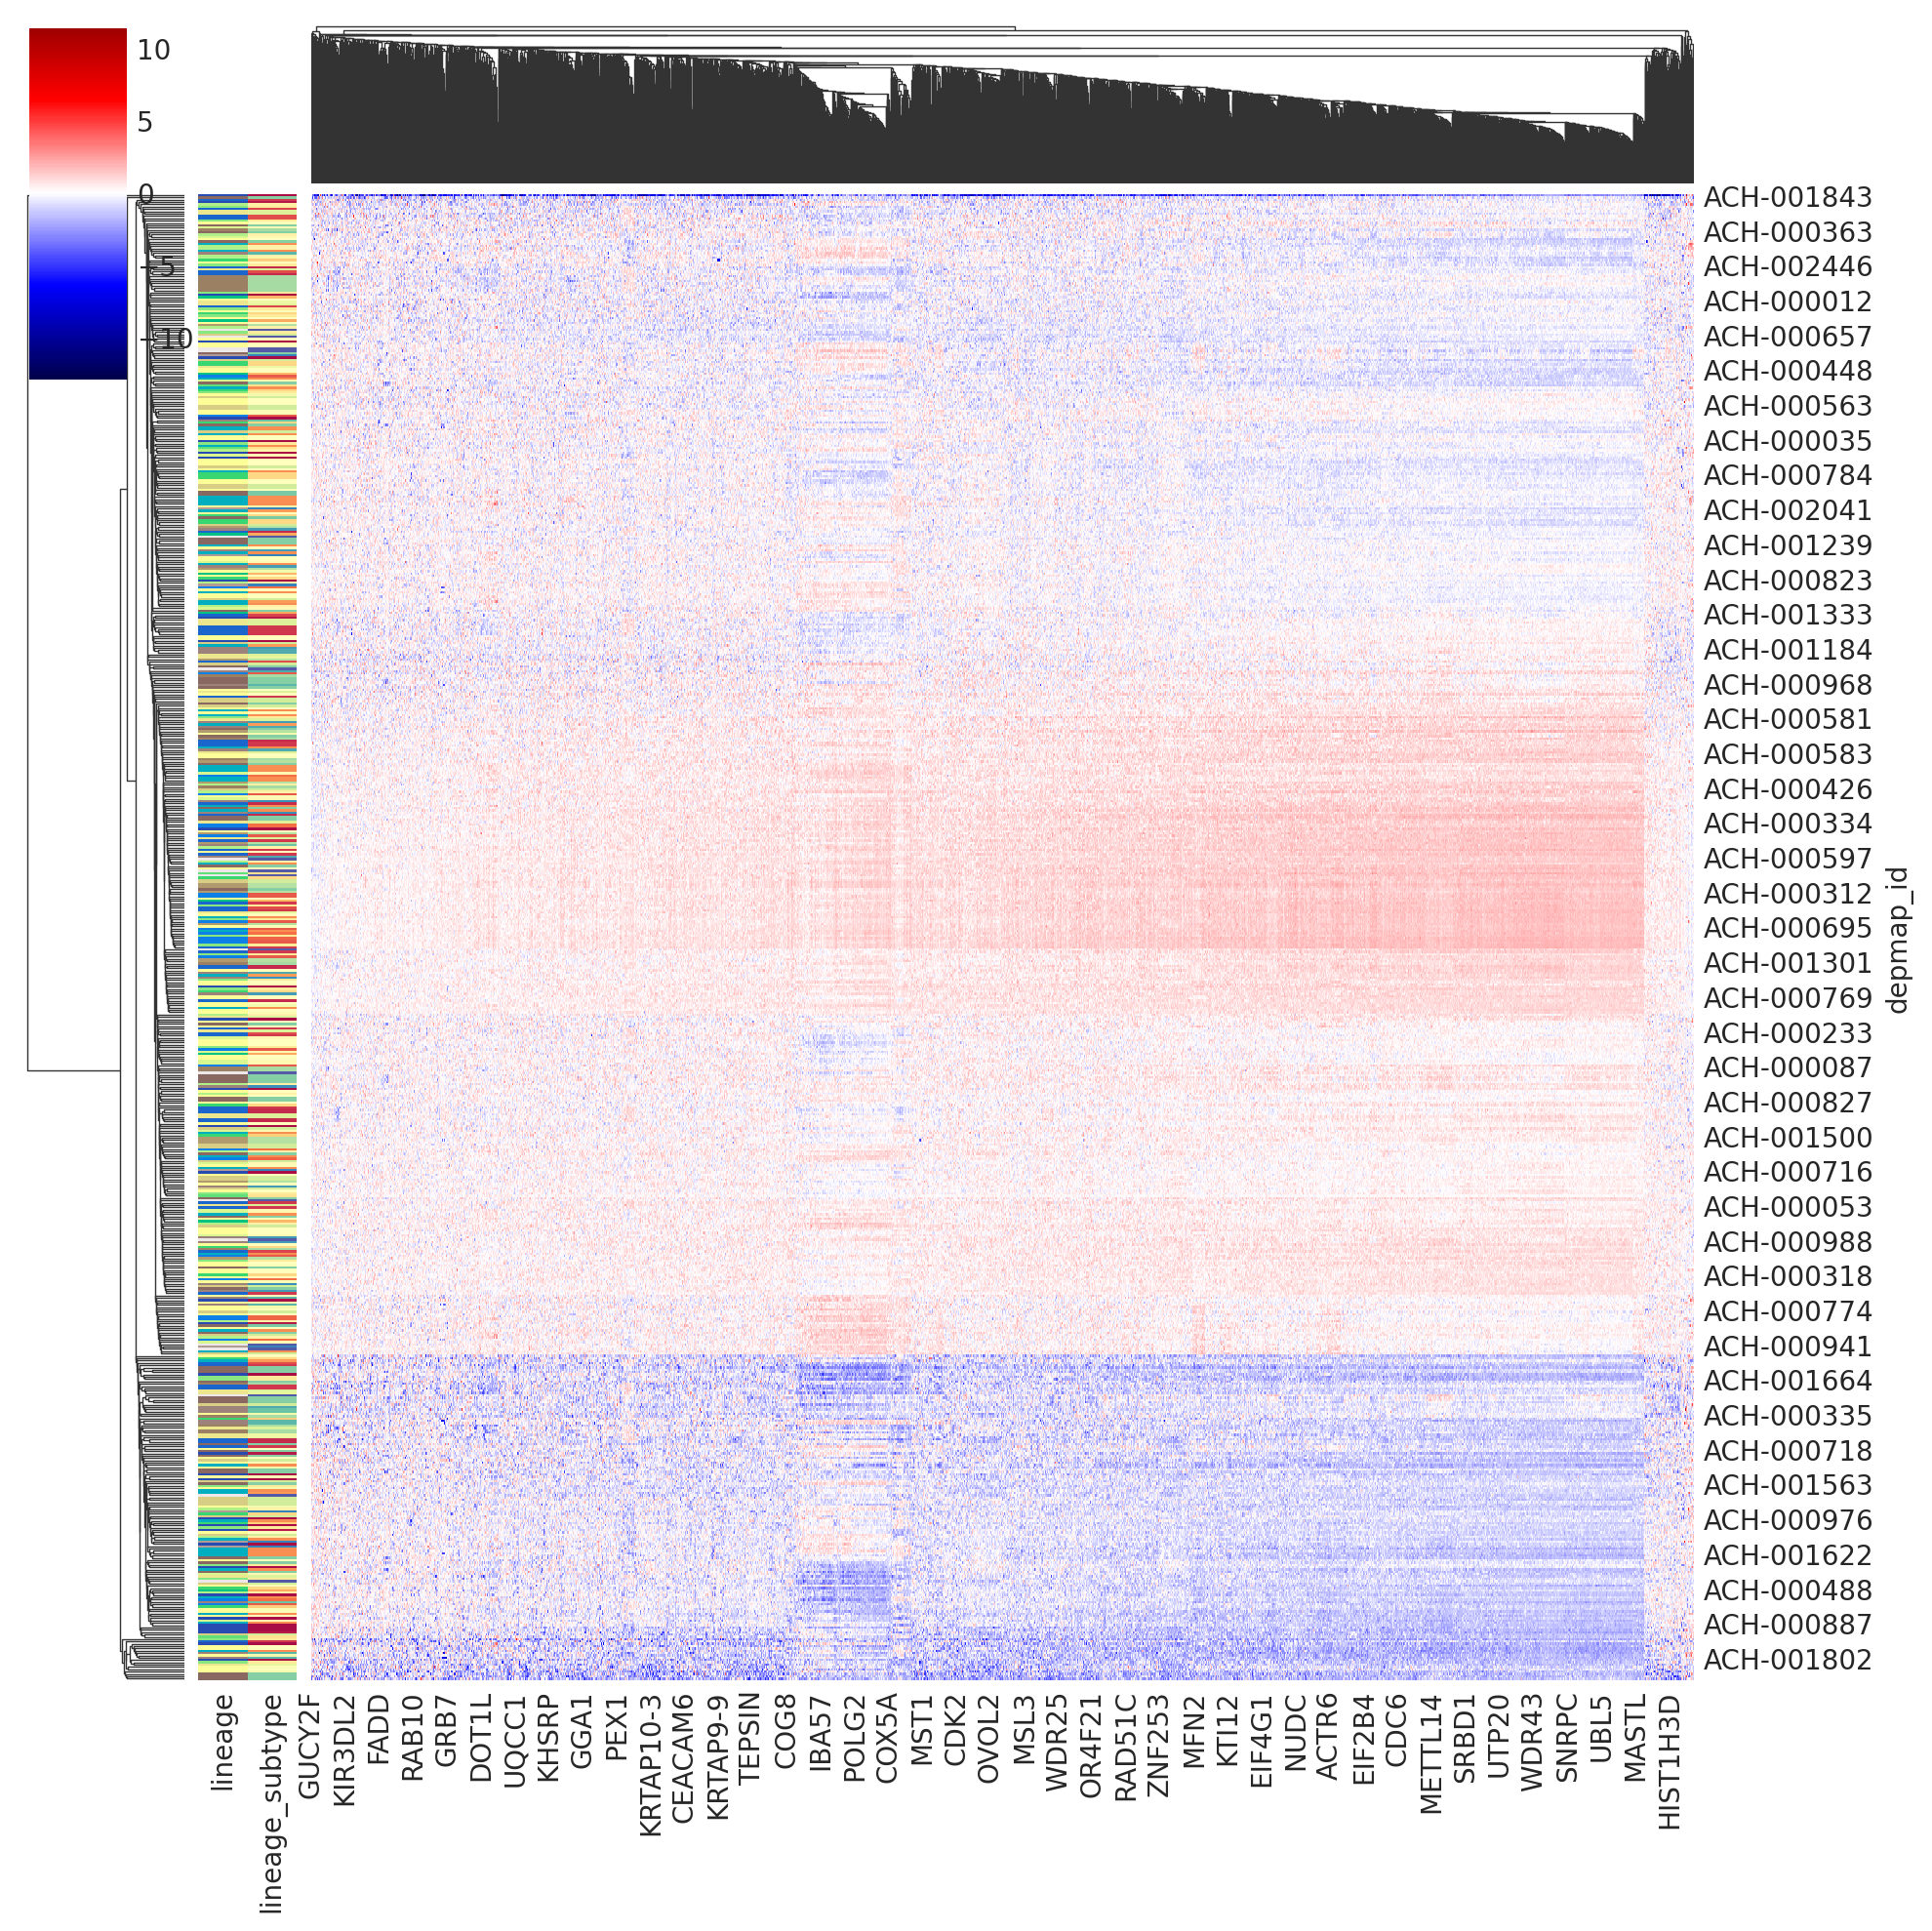

In [16]:
cg = sns.clustermap(
    top_var_data_X,
    z_score=1,
    cmap="seismic",
    center=0,
    row_colors=top_var_cg_row_colors,
    dendrogram_ratio=(0.1, 0.1),
)
plt.show()

In [17]:
top_var_data_X.to_csv(OUTPUT_DIR / "top-variance-genes-data-wide.csv")
top_var_cg_row_labels.to_csv(OUTPUT_DIR / "top-variance-genes-data-row-labels.csv")

### $t$-SNE

In [25]:
tsne_model = TSNE(perplexity=50, learning_rate="auto", init="pca", random_state=20)
tsne_out = tsne_model.fit_transform(top_var_data_X.values)
tsne_res_df = (
    pd.DataFrame(tsne_out, columns=("tsne1", "tsne2"))
    .assign(depmap_id=top_var_data_X.index)
    .merge(top_var_cg_row_labels, left_on="depmap_id", right_index=True)
)
tsne_res_df.head()

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


,tsne1,tsne2,depmap_id,lineage,lineage_subtype
0,-6.110592,-2.862226,ACH-000004,blood,blood (AML)
1,-15.518285,0.109040,ACH-000005,blood,blood (AML)
2,3.857738,-2.359804,ACH-000012,lung,lung (NSCLC)
3,3.877869,-0.606903,ACH-000013,ovary,ovary (ovary adenocarcinoma)
4,3.937296,-0.835792,ACH-000014,skin,skin (melanoma)


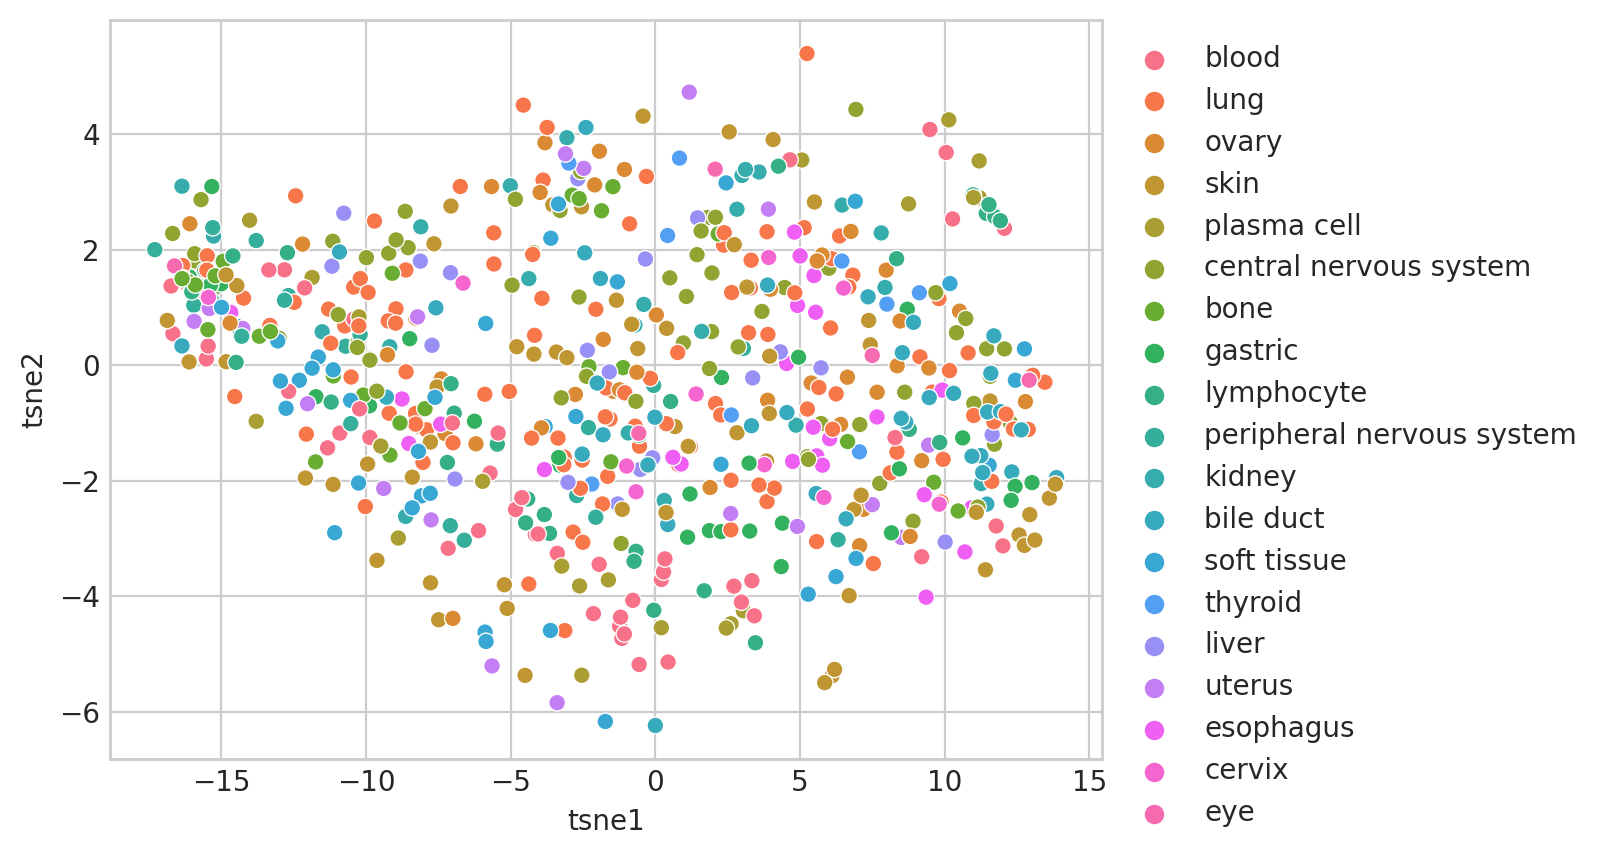

In [26]:
ax = sns.scatterplot(data=tsne_res_df, x="tsne1", y="tsne2", hue="lineage")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [27]:
tsne_res_df.to_csv(OUTPUT_DIR / "top-variance-genes-tsne.csv", index=False)

---

In [28]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.99 minutes


In [29]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2022-10-06

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-229.o2.rc.hms.harvard.edu

Git branch: figures

numpy     : 1.23.3
json      : 2.0.9
seaborn   : 0.11.2
dask      : 2022.9.0
matplotlib: 3.5.3
arviz     : 0.12.1
pandas    : 1.4.4

